--- Network (PINN-SIREN) ---
PINN(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=64, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (final_linear): Linear(in_features=64, out_features=1, bias=True)
)
Params: 12737
Starting Adam (PINN)...
Ep 2500 Loss: 1.47e+03 (PDE: 3.17e+02, BC: 4.59e+00) LamBC: 250.8
Ep 5000 Loss: 5.50e+02 (PDE: 8.15e+01, BC: 9.36e-01) LamBC: 500.5
Ep 7500 Loss: 1.39e+02 (PDE: 2.67e+01, BC: 1.49e-01) LamBC: 750.2
Ep 10000 Loss: 4.95e+01 (PDE: 1.54e+01, BC: 3.41e-02) LamBC: 1000.0
Ep 12500 Loss: 2.30e+03 (PDE: 2.05e+02, BC: 2.10e+00) LamBC: 1000.0
Ep 15000 Loss: 1.21e+03 (PDE: 1.24e+02, BC: 1.09e+00) LamBC: 1000.0
Ep 17500 Loss: 8.68e+02 (PDE: 9.23e+01, BC: 7.75e-01) LamBC

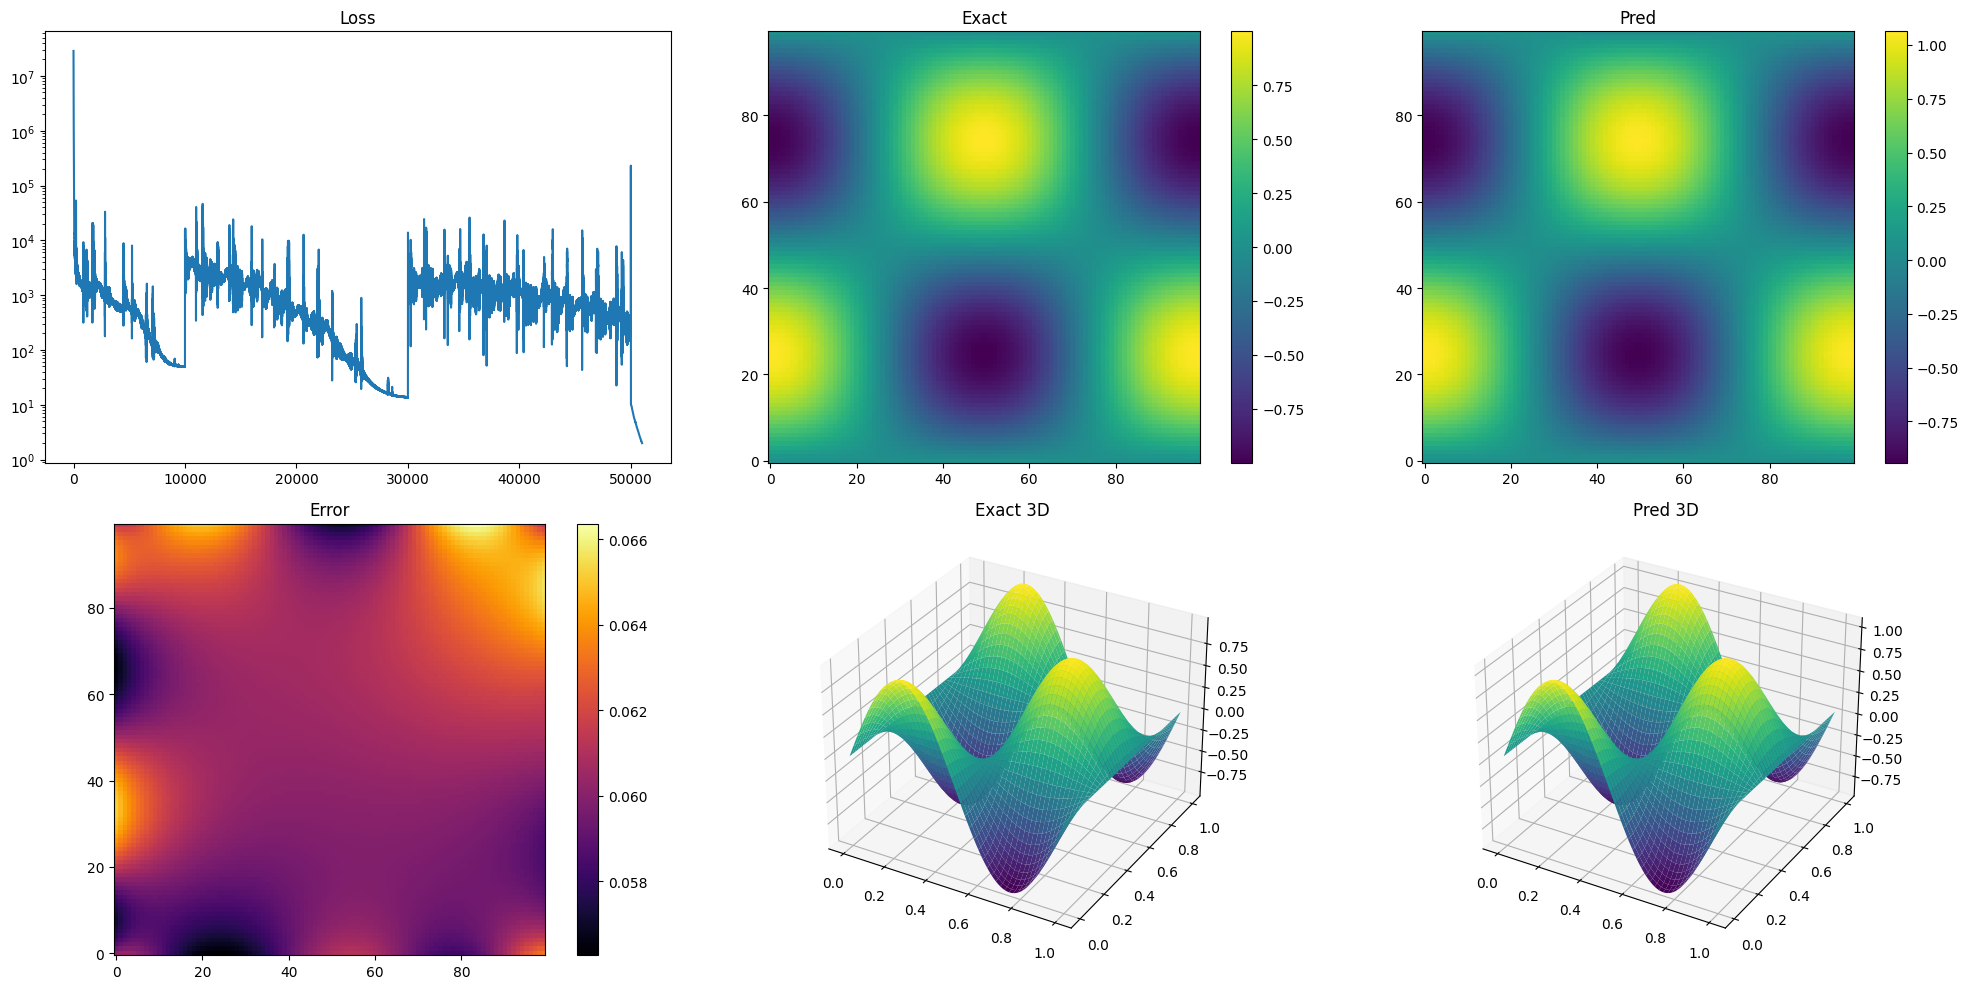

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import pickle

# ---------------------------------------------------------------------
# Configuration & Setup
# ---------------------------------------------------------------------
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for High Precision
# PINNs often need high boundary weights to satisfy essential/natural BCs accurately
LAMBDA_BC_MAX = 1000.0     
LAMBDA_INT = 1.0           
EPOCHS_ADAM = 50000        
EPOCHS_LBFGS = 1000        
LR_MAX = 5e-4              
NUM_POINTS_INT = 10000     # N_i
NUM_POINTS_BND = 4000      # N_b

# ---------------------------------------------------------------------
# 1. Neural Network (SIREN) - Same robust architecture
# ---------------------------------------------------------------------
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=1.0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.linear.in_features, 
                                             1 / self.linear.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.linear.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.linear.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class PINN(nn.Module):
    def __init__(self, num_layers=3, hidden_size=64):
        super(PINN, self).__init__()
        layers = [SineLayer(2, hidden_size, is_first=True, omega_0=1.0)]
        for _ in range(num_layers):
            layers.append(SineLayer(hidden_size, hidden_size, omega_0=1.0))
        self.net = nn.Sequential(*layers)
        self.final_linear = nn.Linear(hidden_size, 1)
        
        with torch.no_grad():
            self.final_linear.weight.uniform_(-np.sqrt(6 / hidden_size) / 1.0, 
                                               np.sqrt(6 / hidden_size) / 1.0)
            
        self.n_L = sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x):
        # Scale inputs to align with frequency
        return self.final_linear(self.net(2.0 * np.pi * x))

# ---------------------------------------------------------------------
# 2. Problem Definition (Exact Data)
# ---------------------------------------------------------------------
def exact_u_func(x):
    return torch.sin(2 * np.pi * x[:, 0:1]) * torch.cos(2 * np.pi * x[:, 1:2])

def get_exact_source(x):
    # f = Delta^2 u = 64 * pi^4 * u
    u = exact_u_func(x)
    return 64 * (np.pi ** 4) * u

def get_exact_boundary_data(x, n):
    # g1 = du/dn
    # g2 = d(Delta u)/dn
    x_temp = x.clone().detach().requires_grad_(True)
    u = exact_u_func(x_temp)
    
    # 1st Deriv
    grad_u = torch.autograd.grad(u, x_temp, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    g1 = torch.sum(grad_u * n, dim=1, keepdim=True)
    
    # Laplacian
    u_xx = torch.autograd.grad(grad_u[:, 0:1], x_temp, grad_outputs=torch.ones_like(grad_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(grad_u[:, 1:2], x_temp, grad_outputs=torch.ones_like(grad_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    lap_u = u_xx + u_yy
    
    # Grad(Laplacian)
    grad_lap_u = torch.autograd.grad(lap_u, x_temp, grad_outputs=torch.ones_like(lap_u), create_graph=True)[0]
    g2 = torch.sum(grad_lap_u * n, dim=1, keepdim=True)
    
    return g1.detach(), g2.detach()

# ---------------------------------------------------------------------
# 3. Derivatives Helper (Up to 4th order for PINN)
# ---------------------------------------------------------------------
def compute_pinn_derivatives(u, x):
    # 1st
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    # 2nd (Laplacian parts)
    u_xx = torch.autograd.grad(grad_u[:, 0:1], x, grad_outputs=torch.ones_like(grad_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(grad_u[:, 1:2], x, grad_outputs=torch.ones_like(grad_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    lap_u = u_xx + u_yy
    
    # 3rd (Grad of Laplacian) - Needed for BC g2
    grad_lap_u = torch.autograd.grad(lap_u, x, grad_outputs=torch.ones_like(lap_u), create_graph=True)[0]
    
    # 4th (Bi-Laplacian) - Needed for PDE residual f
    lap_u_xx = torch.autograd.grad(grad_lap_u[:, 0:1], x, grad_outputs=torch.ones_like(grad_lap_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    lap_u_yy = torch.autograd.grad(grad_lap_u[:, 1:2], x, grad_outputs=torch.ones_like(grad_lap_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    bilap_u = lap_u_xx + lap_u_yy
    
    return grad_u, grad_lap_u, bilap_u

# ---------------------------------------------------------------------
# 4. PINN Loss Function (Matches PDF P4)
# ---------------------------------------------------------------------
def loss_function_pinn(model, x_int, x_bnd, n_bnd, f_exact, g1_exact, g2_exact, lambda_bc):
    # --- Interior Loss ---
    x_int.requires_grad_(True)
    u_int = model(x_int)
    
    _, _, bilap_u_int = compute_pinn_derivatives(u_int, x_int)
    
    # Term 1: PDE Residual |Delta^2 u - f|^2
    res_pde = bilap_u_int - f_exact
    loss_pde = torch.mean(res_pde**2)
    
    # Term 2: Mean Constraint (Integral u)^2 approx (Mean u)^2
    mean_u = torch.mean(u_int)
    loss_mean = mean_u**2
    
    loss_int = loss_pde + loss_mean
    
    # --- Boundary Loss ---
    x_bnd.requires_grad_(True)
    u_bnd = model(x_bnd)
    
    grad_u_bnd, grad_lap_u_bnd, _ = compute_pinn_derivatives(u_bnd, x_bnd)
    
    # Term 3: |du/dn - g1|^2
    du_dn = torch.sum(grad_u_bnd * n_bnd, dim=1, keepdim=True)
    loss_g1 = torch.mean((du_dn - g1_exact)**2)
    
    # Term 4: |d(Delta u)/dn - g2|^2
    d_lap_u_dn = torch.sum(grad_lap_u_bnd * n_bnd, dim=1, keepdim=True)
    loss_g2 = torch.mean((d_lap_u_dn - g2_exact)**2)
    
    loss_bc = loss_g1 + loss_g2
    
    # Total PINN Loss
    total_loss = LAMBDA_INT * loss_int + lambda_bc * loss_bc
    return total_loss, loss_pde, loss_bc

# ---------------------------------------------------------------------
# 5. Sobol Sampling
# ---------------------------------------------------------------------
def get_sobol_points(n_int, n_bnd):
    # Interior
    sobol_int = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
    x_int = sobol_int.draw(n_int).to(DEVICE).to(torch.float64)
    
    # Boundary
    sobol_bnd = torch.quasirandom.SobolEngine(dimension=1, scramble=True)
    n_side = n_bnd // 4
    t = sobol_bnd.draw(n_side).to(DEVICE).to(torch.float64).flatten()
    zeros = torch.zeros_like(t); ones = torch.ones_like(t)
    
    pts = [
        (torch.stack([t, zeros], 1), [0., -1.]),
        (torch.stack([t, ones], 1),  [0., 1.]),
        (torch.stack([zeros, t], 1), [-1., 0.]),
        (torch.stack([ones, t], 1),  [1., 0.])
    ]
    x_b = torch.cat([p[0] for p in pts], 0)
    n_b = torch.cat([torch.tensor([p[1]], device=DEVICE).repeat(n_side, 1) for p in pts], 0)
    
    return x_int, x_b, n_b

# ---------------------------------------------------------------------
# 6. Training Loop
# ---------------------------------------------------------------------
def main():
    model = PINN(num_layers=3, hidden_size=64).to(DEVICE)
    print(f"--- Network (PINN-SIREN) ---\n{model}")
    print(f"Params: {model.n_L}")
    
    optimizer_adam = optim.Adam(model.parameters(), lr=LR_MAX)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_adam, T_0=10000, T_mult=2, eta_min=1e-6)
    
    optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=0.5, max_iter=EPOCHS_LBFGS,
                                  history_size=100, tolerance_grad=1e-9, tolerance_change=1e-11,
                                  line_search_fn="strong_wolfe")
    
    loss_history = []
    
    # Fixed validation set for LBFGS to prevent noise
    x_int_fix, x_bnd_fix, n_bnd_fix = get_sobol_points(NUM_POINTS_INT, NUM_POINTS_BND)
    f_fix = get_exact_source(x_int_fix)
    g1_fix, g2_fix = get_exact_boundary_data(x_bnd_fix, n_bnd_fix)
    
    print("Starting Adam (PINN)...")
    for epoch in range(1, EPOCHS_ADAM + 1):
        # Curriculum for Boundary Weights
        if epoch <= 10000:
            alpha = epoch / 10000.0
            cur_lambda_bc = 1.0 + alpha * (LAMBDA_BC_MAX - 1.0)
        else:
            cur_lambda_bc = LAMBDA_BC_MAX
            
        # Resample interior for stochasticity (prevents overfitting to specific points)
        x_int, x_bnd, n_bnd = get_sobol_points(NUM_POINTS_INT, NUM_POINTS_BND)
        f_exact = get_exact_source(x_int)
        g1_exact, g2_exact = get_exact_boundary_data(x_bnd, n_bnd)
        
        optimizer_adam.zero_grad()
        loss, l_pde, l_bc = loss_function_pinn(model, x_int, x_bnd, n_bnd, 
                                               f_exact, g1_exact, g2_exact, cur_lambda_bc)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_adam.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if epoch % 2500 == 0:
            print(f"Ep {epoch} Loss: {loss.item():.2e} (PDE: {l_pde.item():.2e}, BC: {l_bc.item():.2e}) LamBC: {cur_lambda_bc:.1f}")

    print("Running LBFGS Polish...")
    def closure():
        optimizer_lbfgs.zero_grad()
        loss, _, _ = loss_function_pinn(model, x_int_fix, x_bnd_fix, n_bnd_fix, 
                                        f_fix, g1_fix, g2_fix, LAMBDA_BC_MAX)
        loss.backward()
        loss_history.append(loss.item())
        return loss
    optimizer_lbfgs.step(closure)
    
    print(f"Final Loss: {loss_history[-1]:.6e}")
    
    # --- Analysis ---
    n_test = 100
    x1 = torch.linspace(0, 1, n_test)
    x2 = torch.linspace(0, 1, n_test)
    X, Y = torch.meshgrid(x1, x2, indexing='ij')
    x_test = torch.stack([X.flatten(), Y.flatten()], dim=1).to(DEVICE)
    x_test.requires_grad_(True)
    
    u_exact = exact_u_func(x_test)
    u_pred = model(x_test)
    
    # Calculate H1/H2 Errors
    grad_u_p, _, bilap_p = compute_pinn_derivatives(u_pred, x_test)
    grad_u_e, _, bilap_e = compute_pinn_derivatives(u_exact, x_test)
    
    # For H2 we need full Hessian, compute_pinn_derivatives gives bi-laplacian. 
    # Let's re-use the generic hessian helper.
    def get_hessian(u, x):
        grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux, uy = grads[:,0:1], grads[:,1:2]
        return torch.cat([
            torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0][:,0:1],
            torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0][:,1:2],
            torch.autograd.grad(uy, x, grad_outputs=torch.ones_like(uy), create_graph=True)[0][:,0:1],
            torch.autograd.grad(uy, x, grad_outputs=torch.ones_like(uy), create_graph=True)[0][:,1:2]
        ], dim=1)
        
    hess_pred = get_hessian(u_pred, x_test)
    hess_exact = get_hessian(u_exact, x_test)
    
    err_sq_u = (u_pred - u_exact)**2
    err_sq_grad = torch.sum((grad_u_p - grad_u_e)**2, dim=1)
    err_sq_hess = torch.sum((hess_pred - hess_exact)**2, dim=1)
    
    l2_err = np.sqrt(torch.mean(err_sq_u).item())
    h1_err = np.sqrt(torch.mean(err_sq_u + err_sq_grad).item())
    h2_err = np.sqrt(torch.mean(err_sq_u + err_sq_grad + err_sq_hess).item())
    
    norm_u = np.sqrt(torch.mean(u_exact**2).item())
    norm_h1 = np.sqrt(torch.mean(u_exact**2 + torch.sum(grad_u_e**2, 1)).item())
    norm_h2 = np.sqrt(torch.mean(u_exact**2 + torch.sum(grad_u_e**2, 1) + torch.sum(hess_exact**2, 1)).item())
    
    print("\n--- Errors ---")
    print(f"L2: {l2_err:.4e} (Rel: {l2_err/norm_u:.4e})")
    print(f"H1: {h1_err:.4e} (Rel: {h1_err/norm_h1:.4e})")
    print(f"H2: {h2_err:.4e} (Rel: {h2_err/norm_h2:.4e})")
    
    # Plotting
    u_p = u_pred.detach().cpu().numpy().reshape(n_test, n_test)
    u_e = u_exact.detach().cpu().numpy().reshape(n_test, n_test)
    
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(2, 3, 1); ax1.plot(loss_history); ax1.set_yscale('log'); ax1.set_title('Loss')
    ax2 = fig.add_subplot(2, 3, 2); im2=ax2.imshow(u_e, origin='lower'); plt.colorbar(im2, ax=ax2); ax2.set_title('Exact')
    ax3 = fig.add_subplot(2, 3, 3); im3=ax3.imshow(u_p, origin='lower'); plt.colorbar(im3, ax=ax3); ax3.set_title('Pred')
    ax4 = fig.add_subplot(2, 3, 4); im4=ax4.imshow(np.abs(u_p-u_e), origin='lower', cmap='inferno'); plt.colorbar(im4, ax=ax4); ax4.set_title('Error')
    
    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    X_np, Y_np = X.detach().cpu().numpy(), Y.detach().cpu().numpy()
    ax5.plot_surface(X_np, Y_np, u_e, cmap='viridis')
    ax5.set_title('Exact 3D')
    
    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    ax6.plot_surface(X_np, Y_np, u_p, cmap='viridis')
    ax6.set_title('Pred 3D')
    
    plt.tight_layout()
    plt.savefig('pinn_p4_results.png')
    
    with open("pinn_loss_history.pkl", "wb") as f: pickle.dump(loss_history, f)
    torch.save(model.state_dict(), "pinn_model.pth")

if __name__ == "__main__":
    main()